# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [16]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [17]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [18]:
train_x = np.linspace(0, 1, 50)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [19]:
train_x.shape, train_y.shape

((50,), (50, 3))

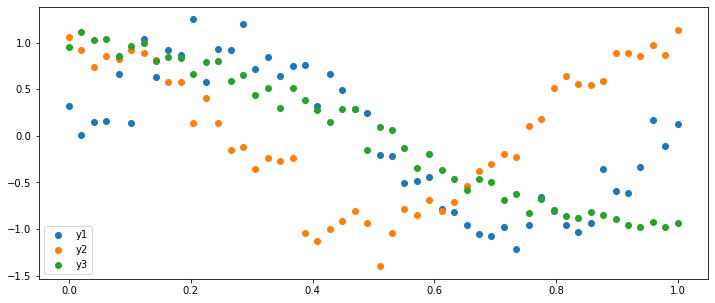

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [21]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [22]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

### ICM: one kernel

In [23]:
import aesara.tensor as at

In [24]:
task_i = np.linspace(0, 1, 3)[:, None]
Xs = [task_i, x]
Xs[0].shape, Xs[1].shape, x.shape

((3, 1), (50, 1), (50, 1))

In [25]:
Xnew = pm.math.cartesian(task_i, x)
Xnew.shape

(150, 2)

In [40]:
# Create a Coregion Matrix B as a Covariance
class CoregionMatrix(Covariance):
    r"""
    Coregion Matrix valued covariance function.

    .. math::

       k(x, x') = B(x, x')
    """

    def __init__(self, W, B):
        super().__init__(1, None)
        self.W = W
        self.B = B
        self.n_outputs = B.shape[0]

    def diag(self, X):
        return at.alloc(self.B, X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return at.alloc(self.B, X.shape[0], X.shape[0])
        else:
            return at.alloc(self.B, X.shape[0], Xs.shape[0])

### Create a model

In [41]:
JITTER_DEFAULT = 1e-6
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    #cov2= pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    W = np.random.rand(3,2) # (n_outputs, w_rank)
    kappa = np.random.rand(3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa)) 
    B = B + JITTER_DEFAULT * at.identity_like(B)
    coreg = CoregionMatrix(W=W, B=B)
    
    mogp = pm.gp.LatentKron(cov_funcs=[coreg, cov])
    sigma = pm.HalfNormal("sigma", sigma=3)    
    
    # Place a GP prior over the function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

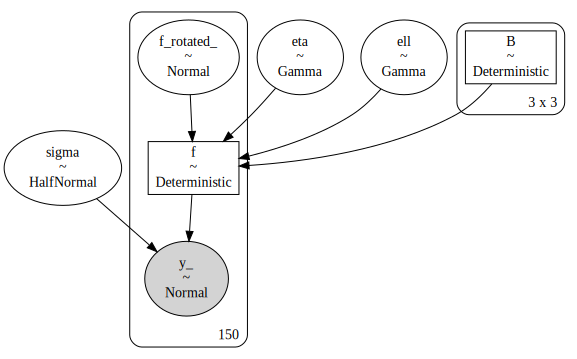

In [42]:
pm.model_to_graphviz(model)

In [43]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 69 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 1min 21s, sys: 3min 11s, total: 4min 33s
Wall time: 1min 14s


In [44]:
with model:
    preds = mogp.conditional("preds", Xnew)

In [45]:
with model:
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42, keep_size=False)

AssertionError: Shapes must be equal
Apply node that caused the error: Assert{msg=Shapes must be equal}(Elemwise{Composite{(i0 + (i1 * i2))}}[(0, 2)].0, All.0)
Toposort index: 29
Inputs types: [TensorType(float64, (None, None)), TensorType(bool, ())]
Inputs shapes: [(3, 3), ()]
Inputs strides: [(24, 8), ()]
Inputs values: ['not shown', array(False)]
Outputs clients: [[Elemwise{Composite{(i0 * exp((i1 * clip((i2 + i3 + i4), i5, i6))) * i7)}}[(0, 0)](Assert{msg=Shapes must be equal}.0, TensorConstant{(1, 1) of -0.5}, Dot22Scalar.0, InplaceDimShuffle{0,x}.0, InplaceDimShuffle{x,0}.0, TensorConstant{(1, 1) of 0.0}, TensorConstant{(1, 1) of inf}, Elemwise{sqr,no_inplace}.0)]]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
# x1new = np.array([0,1,2])
# n_points = 50
# # x2new = np.linspace(-0.5, 1.5, n_points)[:, None]
# x2new = np.linspace(0, 1.0, n_points)[:, None]
# Xnew = pm.math.cartesian(x1new, x2new)
# x1new.shape, x2new.shape, Xnew.shape

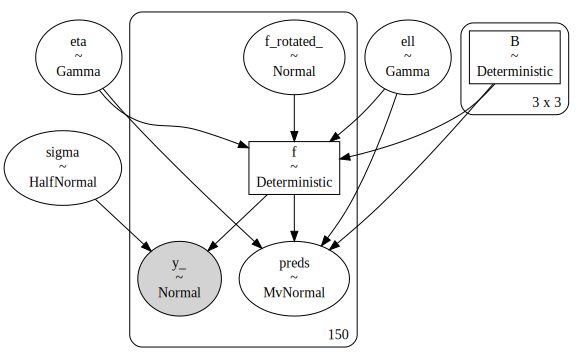

In [34]:
pm.model_to_graphviz(model)

In [35]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

NameError: name 'gp_samples' is not defined

In [ ]:
az.summary(gp_trace)

### LCM: two or more kernels

In [19]:
# with pm.Model() as model:
#     # Priors
#     ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
#     eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
#     kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
#     sigma = pm.HalfNormal("sigma", sigma=3)
    
#     # Define a list of covariance functions
#     cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
#                 for idx, kernel in enumerate(kernels)]
    
#     # Define a Multi-output GP 
#     mogp = MultiOutputMarginal(means=0, kernels=cov_list, input_dim=2, active_dims=[1], num_outputs=3)    
#     y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)    

In [118]:
# pm.model_to_graphviz(model)

In [ ]:
# %%time
# with model:
#     gp_trace = pm.sample(500, chains=1)

In [ ]:
# with model:
#     preds = mogp.conditional("preds", X_new)
#     gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

In [ ]:
# pm.model_to_graphviz(model)

In [ ]:
# from pymc.gp.util import plot_gp_dist

# f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
# fig, axes = plt.subplots(3,1, figsize=(8,12))

# for idx in range(3):
#     plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
#                  X_new[n_points*idx:n_points*(idx+1),0], 
#                  palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
#     axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [ ]:
# az.summary(gp_trace)

In [ ]:
# az.plot_trace(gp_trace);
# plt.tight_layout()